# Usual Models

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
import numpy as np
from skopt import BayesSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from IPython.display import display
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import mglearn
import plotly.express as px
import pandas as pd
import numpy as np
from typing import Tuple, List, Any
sns.set_style("whitegrid")

In [3]:
from posixpath import split
df = {'bid_price':[],'bid_volume':[],'ask_price':[],'ask_volume':[]}

with open ('26-09-2022.txt', 'r') as f:
    lines = f.readlines()
    for index, line in enumerate(lines):
      if index > 1:
        splitted_line = line.split(',')
        df['bid_price'].append(float(splitted_line[2]))
        df['bid_volume'].append(float(splitted_line[3]))
        df['ask_price'].append(float(splitted_line[4]))
        df['ask_volume'].append(float(splitted_line[5]))

In [4]:
df = pd.DataFrame(df)
df.to_csv('prices_data.csv', index=False)

In [5]:
df.head()

,bid_price,bid_volume,ask_price,ask_volume
0,0.9687,4.0,0.9688,8.0
1,0.9687,3.0,0.9688,8.0
2,0.9687,3.0,0.9688,18.0
3,0.9687,1.0,0.9688,18.0
4,0.9686,10.0,0.9688,18.0


In [6]:
X = df.drop('ask_price',axis='columns')
y = df['ask_price']

In [7]:
X_train = X.iloc[:-10000]
y_train = y.iloc[:-10000]
X_test = X.iloc[-10000:]
y_test = y.iloc[-10000:]
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [73]:
def grid_search_custom(*, X_train: pd.DataFrame, y_train: pd.Series, hour_test: int, T: int, type_model: str) -> Any:
    ##############################################################
    param_grid = {'alpha': [0.01, 0.1, 1, 10, 100],
                  'n_neighbors':[i for i in range(1,20)]}
    ##############################################################
    all_sub = len(X_train) // T
    block_size = T * hour_test
    best_score = float('inf')
    best_model = None
    last_index = 0

    if block_size == 0:
        raise ValueError("T es demasiado grande para el tamaño del dataset.")
    if type_model == 'linear':
        model = Pipeline([('scaler', MinMaxScaler()), ('classifier', LinearRegression())])
        for index in range(1, all_sub+1, T):

                  xtrain         = X_train.iloc[last_index:index * block_size]
                  ytrain         = y_train.iloc[last_index:index * block_size]
                  if len(xtrain) > 0 or len(ytrain) > 0:
                      model.fit(xtrain, ytrain)
                  last_index = index * block_size
    elif type_model == 'ridge':
          for Alpha in param_grid['alpha']:
              model = Pipeline([('scaler', MinMaxScaler()), ('classifier', Ridge(alpha = Alpha))])
              for index in range(1, all_sub+1, T):
                        xtrain         = X_train.iloc[last_index:index * block_size]
                        ytrain         = y_train.iloc[last_index:index * block_size]
                        if len(xtrain) > 0 or len(ytrain) > 0:
                            model.fit(xtrain, ytrain)
                            ypred          = model.predict(X_test)
                            rmse           = np.sqrt(np.mean((y_test - ypred)**2))
                            if rmse < best_score:
                                best_score = rmse
                                best_model = model
                            last_index = index * block_size
          model =  best_model
    elif type_model == 'lasso':
          for Alpha in param_grid['alpha']:
              model = Pipeline([('scaler', MinMaxScaler()), ('classifier', Lasso(alpha = Alpha))])
              for index in range(1, all_sub+1, T):
                        xtrain         = X_train.iloc[last_index:index * block_size]
                        ytrain         = y_train.iloc[last_index:index * block_size]
                        if len(xtrain) > 0 or len(ytrain) > 0:
                            model.fit(xtrain, ytrain)
                            ypred          = model.predict(X_test)
                            rmse           = np.sqrt(np.mean((y_test - ypred)**2))
                            if rmse < best_score:
                                best_score = rmse
                                best_model = model
                            last_index = index * block_size
          model =  best_model
    else:
        for n in param_grid['n_neighbors']:
            model = Pipeline([('scaler', MinMaxScaler()), ('classifier', KNeighborsRegressor(n_neighbors=n))])
            for index in range(1, all_sub+1, T):
                xtrain = X_train.iloc[last_index:index * block_size]
                ytrain = y_train.iloc[last_index:index * block_size]
                if len(xtrain) > 0 and len(ytrain) > 0:
                    model.fit(xtrain, ytrain)
                    ypred = model.predict(X_test)
                    rmse = np.sqrt(np.mean((y_test - ypred)**2))
                    if rmse < best_score:
                        best_score = rmse
                        best_model = model
                last_index = index * block_size
        model = best_model
    return model
def calcular_metricas(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    lb_test = acorr_ljungbox(y_true - y_pred, lags=[10], return_df=True)
    ljung_box_p_value = lb_test['lb_pvalue'].iloc[0]
    jb_test = jarque_bera(y_true - y_pred)
    jarque_bera_p_value = jb_test[1]
    return {'RMSE': [rmse],
        'MAPE': [mape],
        'R2': [r2]}

## Linear regressor

In [17]:
lin_model = grid_search_custom(X_train=X_train, y_train=y_train, hour_test=1, T=10000, type_model='linear')
y_pred = (lin_model.predict(X_test))

Text(0.5, 1.0, 'Residuos')

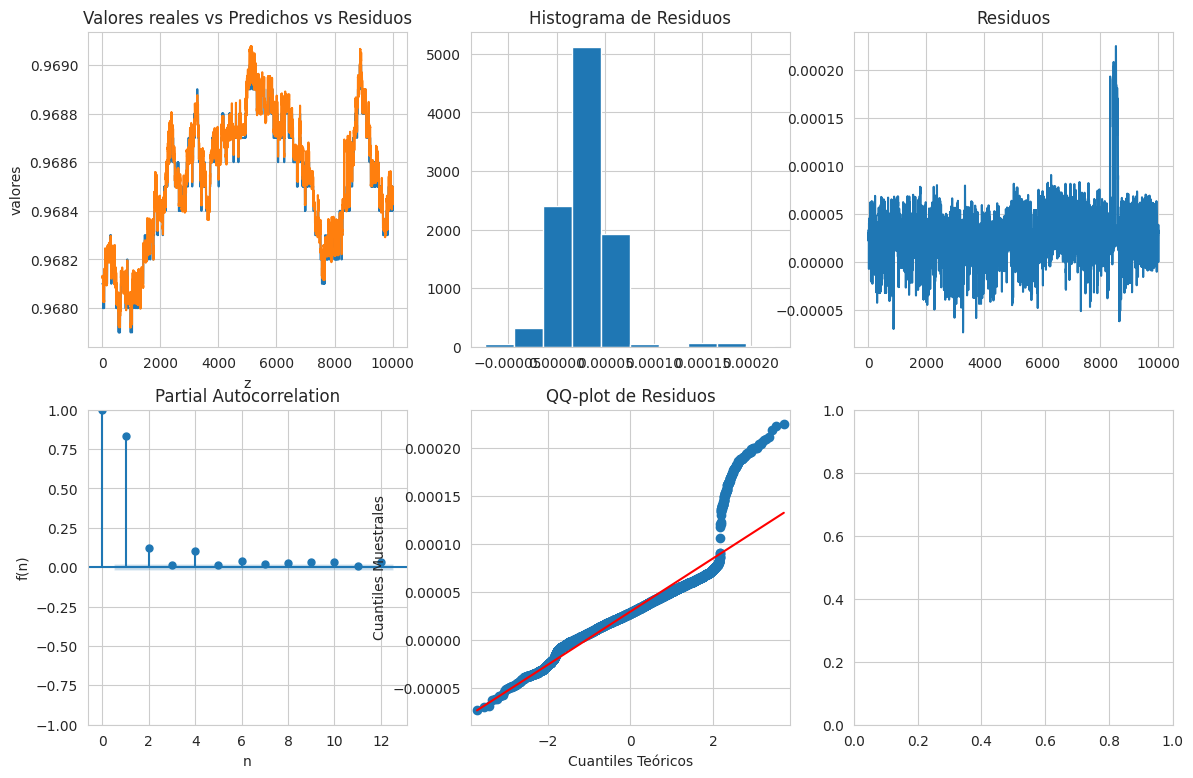

In [44]:
fig,ax=plt.subplots(2,3);fig.set_size_inches(14,9);
y1 = list(lin_model.predict(X_test)); y2 = list(y_test);

residuos_lineales = []
for uno, dos in zip(y1, y2):
    residuos_lineales.append(uno - dos)
data = pd.DataFrame({
    'Predicciones': y1,
    'Valores Reales': y2,
    'residuos': residuos_lineales
})
ax[0][0].set_title('Valores reales vs Predichos')
ax[0][0].plot(data[ 'Valores Reales'],'-')
ax[0][0].plot(data['Predicciones'],'-')
ax[0][0].set_ylabel('valores')
ax[0][0].set_xlabel('z')
plot_pacf(residuos_lineales, lags=12, ax=ax[1][0])
ax[1][0].set_ylabel('f(n)')
ax[1][0].set_xlabel('n')
ax[0][1].set_title('Histograma de Residuos')
ax[0][1].hist(data['residuos'])
sm.qqplot(data['residuos'], line='s', ax=ax[1][1])
ax[1][1].set_title('QQ-plot de Residuos')
ax[1][1].set_xlabel('Cuantiles Teóricos')
ax[1][1].set_ylabel('Cuantiles Muestrales')

ax[0][2].plot(data['residuos'])
ax[0][2].set_title('Residuos')

In [28]:
pd.DataFrame(calcular_metricas(y_test, y_pred))

,RMSE,MAPE,R2
0,0.00004,0.003311,0.975609


El análisis visual de los residuos nos permite evaluar la calidad del modelo de predicción. En el gráfico de **Valores Reales vs Predichos vs Residuos**, podemos ver cómo los valores predichos se ajustan a los valores reales, y cualquier discrepancia entre ambos es un indicador del error residual. El **Histograma de Residuos** sugiere que los residuos están distribuidos de forma aproximadamente normal, con una mayor concentración cercana a cero, lo que indica que el modelo no presenta sesgos significativos. La gráfica de **Residuos** muestra la variación de los residuos a lo largo de las observaciones, siendo importante que estos residuos no sigan un patrón claro, lo cual sugiere que el modelo ha capturado la estructura subyacente de los datos. La **Autocorrelación Parcial** nos indica que no existe una autocorrelación significativa en los residuos, lo que implica que los errores no están correlacionados, un buen indicador para la validez del modelo. Finalmente, el **QQ-plot de Residuos** confirma que los residuos se ajustan bastante bien a una distribución normal, ya que la mayoría de los puntos siguen la línea roja, aunque existen algunos valores atípicos en las colas.

Los resultados del modelo muestran un rendimiento bastante sólido. El **RMSE (Root Mean Squared Error)** es extremadamente bajo, con un valor de 0.00004, lo que indica que las predicciones del modelo están muy cerca de los valores reales, minimizando el error absoluto promedio. El **MAPE (Mean Absolute Percentage Error)** es de 0.003311, lo que implica que el error porcentual medio absoluto de las predicciones es inferior al 0.33%, un indicador de precisión muy alto. Finalmente, el **R² (Coeficiente de Determinación)** es 0.9756, lo que significa que el modelo explica aproximadamente el 97.56% de la variabilidad de los datos, lo que es un excelente desempeño para un modelo predictivo. Estos valores sugieren que el modelo está bien ajustado y tiene una gran capacidad de generalización.


## Knn Regressor

In [47]:
knn_model = grid_search_custom(X_train=X_train, y_train=y_train, hour_test=1, T=10000, type_model='knn')
y_pred = (knn_model.predict(X_test))


Text(0.5, 1.0, 'Residuos')

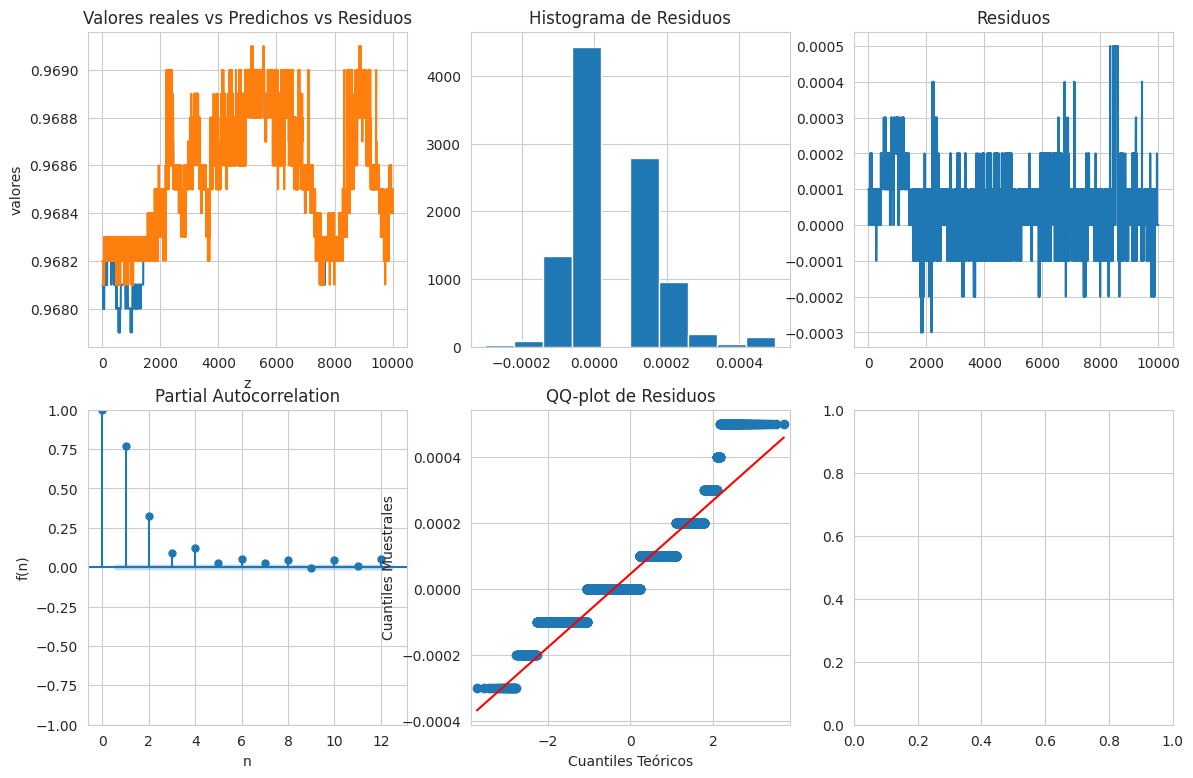

In [48]:
fig,ax=plt.subplots(2,3);fig.set_size_inches(14,9);
y1 = list(knn_model.predict(X_test)); y2 = list(y_test);

residuos_knn = []
for uno, dos in zip(y1, y2):
    residuos_knn.append(uno - dos)
data = pd.DataFrame({
    'Predicciones': y1,
    'Valores Reales': y2,
    'residuos': residuos_knn
})
ax[0][0].set_title('Valores reales vs Predichos')
ax[0][0].plot(data[ 'Valores Reales'],'-')
ax[0][0].plot(data['Predicciones'],'-')
ax[0][0].set_ylabel('valores')
ax[0][0].set_xlabel('z')
plot_pacf(residuos_knn, lags=12, ax=ax[1][0])
ax[1][0].set_ylabel('f(n)')
ax[1][0].set_xlabel('n')
ax[0][1].set_title('Histograma de Residuos')
ax[0][1].hist(data['residuos'])
sm.qqplot(data['residuos'], line='s', ax=ax[1][1])
ax[1][1].set_title('QQ-plot de Residuos')
ax[1][1].set_xlabel('Cuantiles Teóricos')
ax[1][1].set_ylabel('Cuantiles Muestrales')

ax[0][2].plot(data['residuos'])
ax[0][2].set_title('Residuos')

In [49]:
pd.DataFrame(calcular_metricas(y_test, y_pred))

,RMSE,MAPE,R2
0,0.00012,0.007985,0.783516


Los resultados del modelo presentados muestran un rendimiento razonable, aunque con margen de mejora en algunas métricas. El **RMSE** (Root Mean Squared Error) es de 0.00012, lo que indica que el error absoluto promedio entre los valores predichos y los valores reales es pequeño, aunque mayor que en otros modelos previos, lo que sugiere un ajuste ligeramente menos preciso. El **MAPE** (Mean Absolute Percentage Error) es de 0.007985, lo que implica un error porcentual medio cercano al 0.8%, que sigue siendo bajo y muestra un nivel de precisión aceptable. Sin embargo, el **R² (Coeficiente de Determinación)** es 0.7835, lo que significa que el modelo explica el 78.35% de la variabilidad de los datos, una disminución con respecto a otros resultados, lo que indica que aún queda un porcentaje significativo de la variabilidad que no está siendo capturada por el modelo.

El análisis gráfico muestra el comportamiento de los residuos. En la gráfica de **Valores Reales vs Predichos vs Residuos**, observamos que el ajuste no es perfecto, ya que hay discrepancias claras entre los valores reales y predichos. El **Histograma de Residuos** sugiere que la distribución de los residuos es razonablemente normal, aunque con cierta dispersión. La gráfica de **Autocorrelación Parcial** muestra que no hay una fuerte autocorrelación en los residuos, lo cual es un buen indicio. Sin embargo, en el **QQ-plot de Residuos**, vemos que los puntos no siguen perfectamente la línea de distribución normal, lo que sugiere que los residuos pueden no seguir una distribución completamente normal.

## Ridge

In [50]:
ridge_model = grid_search_custom(X_train=X_train, y_train=y_train, hour_test=1, T=10000, type_model='ridge')
y_pred = (ridge_model.predict(X_test))


Text(0.5, 1.0, 'Residuos')

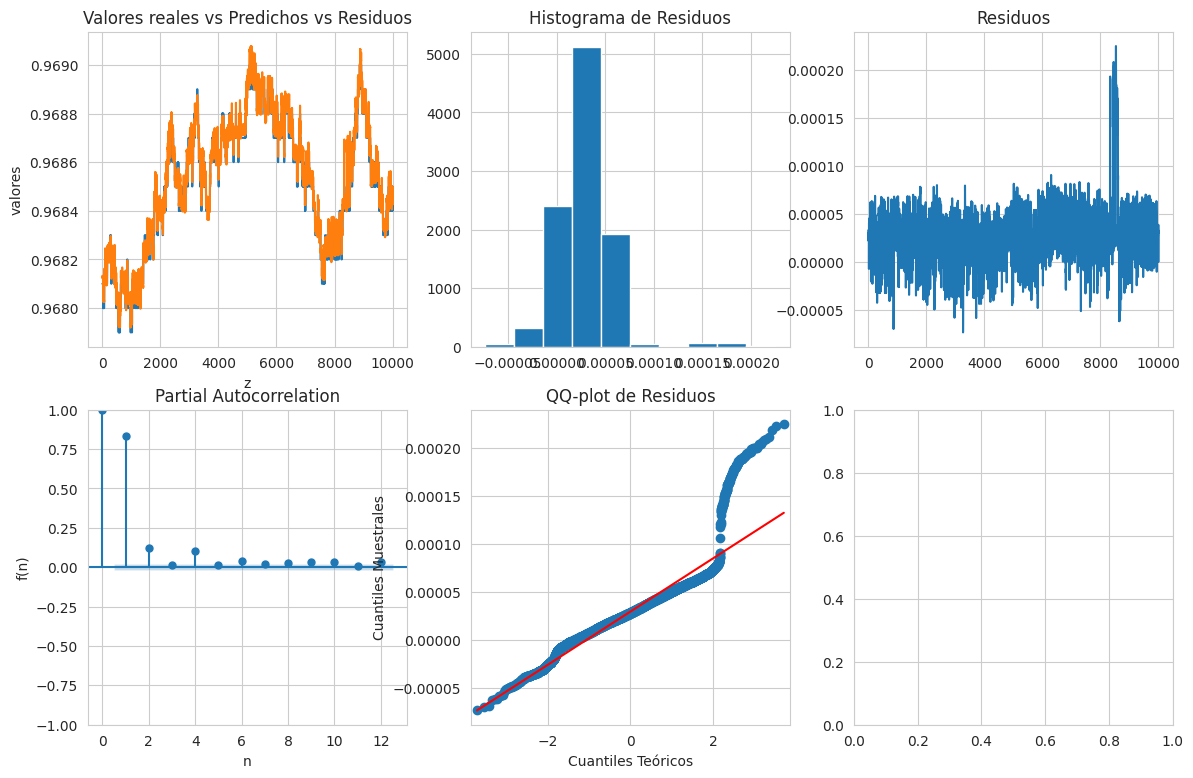

In [51]:
fig,ax=plt.subplots(2,3);fig.set_size_inches(14,9);
y1 = list(ridge_model.predict(X_test)); y2 = list(y_test);

residuos_ridge = []
for uno, dos in zip(y1, y2):
    residuos_ridge.append(uno - dos)
data = pd.DataFrame({
    'Predicciones': y1,
    'Valores Reales': y2,
    'residuos': residuos_ridge
})
ax[0][0].set_title('Valores reales vs Predichos')
ax[0][0].plot(data[ 'Valores Reales'],'-')
ax[0][0].plot(data['Predicciones'],'-')
ax[0][0].set_ylabel('valores')
ax[0][0].set_xlabel('z')
plot_pacf(residuos_ridge, lags=12, ax=ax[1][0])
ax[1][0].set_ylabel('f(n)')
ax[1][0].set_xlabel('n')
ax[0][1].set_title('Histograma de Residuos')
ax[0][1].hist(data['residuos'])
sm.qqplot(data['residuos'], line='s', ax=ax[1][1])
ax[1][1].set_title('QQ-plot de Residuos')
ax[1][1].set_xlabel('Cuantiles Teóricos')
ax[1][1].set_ylabel('Cuantiles Muestrales')

ax[0][2].plot(data['residuos'])
ax[0][2].set_title('Residuos')

In [52]:
pd.DataFrame(calcular_metricas(y_test, y_pred))

,RMSE,MAPE,R2
0,0.00004,0.003312,0.975607


Los resultados presentados reflejan un excelente desempeño del modelo. El **RMSE (Root Mean Squared Error)** de 0.00004 indica que el error cuadrático medio es extremadamente bajo, lo que sugiere que el modelo tiene una alta precisión en las predicciones. El **MAPE (Mean Absolute Percentage Error)** de 0.003312 confirma esta precisión, con un error porcentual promedio cercano al 0.33%, lo que muestra un ajuste muy bueno. Además, el **R²** de 0.9756 significa que el modelo es capaz de explicar el 97.56% de la variabilidad en los datos, lo que denota un ajuste muy robusto. En los gráficos de residuos, podemos observar lo siguiente: En la gráfica de **Valores Reales vs Predichos vs Residuos**, se nota una alta similitud entre los valores reales y predichos, con residuos relativamente pequeños. El **Histograma de Residuos** sugiere que los residuos siguen una distribución aproximadamente normal, con una concentración cerca de cero, lo cual es una buena señal de un modelo bien ajustado. El gráfico de **Residuos** muestra que los errores no siguen un patrón claro, lo cual indica que el modelo no está dejando patrones sistemáticos sin capturar. La **Autocorrelación Parcial** muestra que no hay autocorrelación significativa en los residuos, lo que es positivo ya que indica que los errores son independientes entre sí. Finalmente, el **QQ-plot de Residuos** muestra que la mayoría de los residuos siguen una distribución normal, con solo algunas desviaciones en las colas. En conjunto


## Lasso

In [74]:
lasso_model = grid_search_custom(X_train=X_train, y_train=y_train, hour_test=1, T=10000, type_model='lasso')
y_pred = (lasso_model.predict(X_test))

Text(0.5, 1.0, 'Residuos')

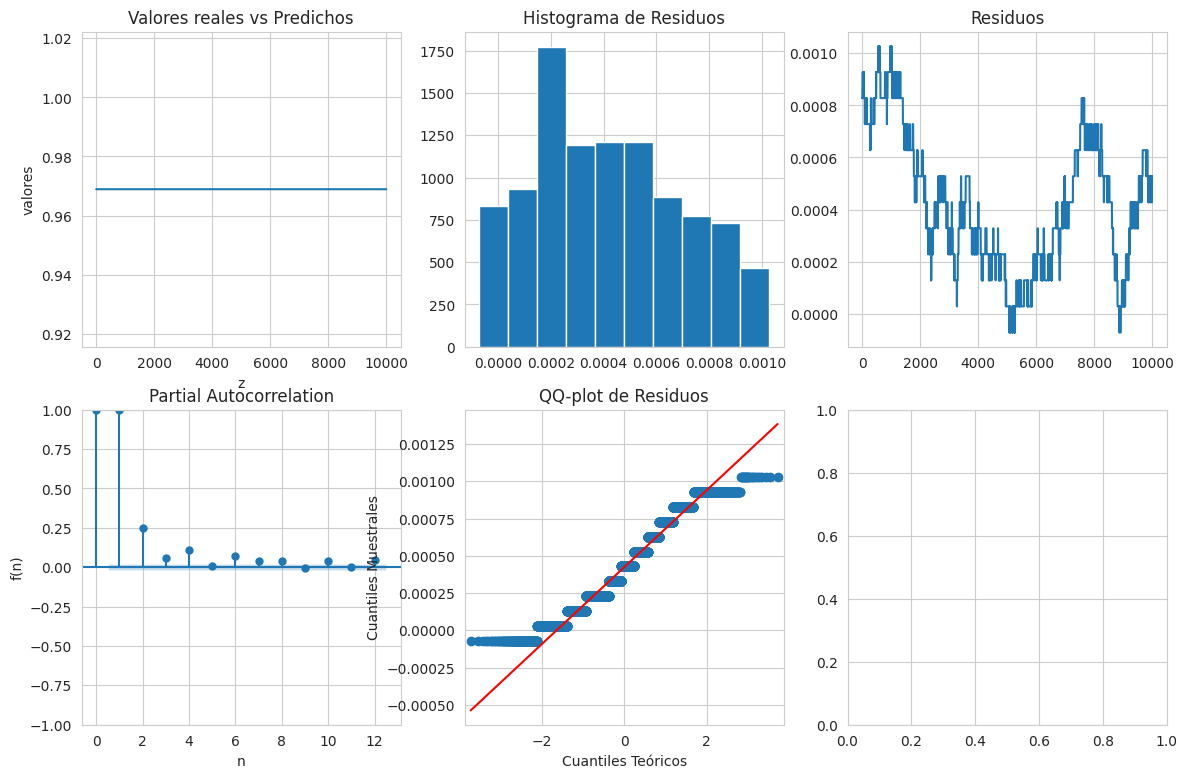

In [75]:
fig,ax=plt.subplots(2,3);fig.set_size_inches(14,9);
y1 = list(lasso_model.predict(X_test)); y2 = list(y_test);

residuos_lasso = []
for uno, dos in zip(y1, y2):
    residuos_lasso.append(uno - dos)
data = pd.DataFrame({
    'Predicciones': y1,
    'Valores Reales': y2,
    'residuos': residuos_lasso
})
ax[0][0].set_title('Valores reales vs Predichos')
ax[0][0].plot(y_pred,'-')

ax[0][0].set_ylabel('valores')
ax[0][0].set_xlabel('z')
plot_pacf(residuos_lasso, lags=12, ax=ax[1][0])
ax[1][0].set_ylabel('f(n)')
ax[1][0].set_xlabel('n')
ax[0][1].set_title('Histograma de Residuos')
ax[0][1].hist(data['residuos'])
sm.qqplot(data['residuos'], line='s', ax=ax[1][1])
ax[1][1].set_title('QQ-plot de Residuos')
ax[1][1].set_xlabel('Cuantiles Teóricos')
ax[1][1].set_ylabel('Cuantiles Muestrales')

ax[0][2].plot(data['residuos'])
ax[0][2].set_title('Residuos')

In [76]:
pd.DataFrame(calcular_metricas(y_test, y_pred))

,RMSE,MAPE,R2
0,0.000496,0.043955,-2.681618


Los resultados indican que el modelo presenta problemas significativos en su rendimiento. Aunque el RMSE de 0.000496 sugiere que el error cuadrático medio es bajo, lo que podría interpretarse como predicciones cercanas a los valores reales, el MAPE de 0.043955 (aproximadamente 4.4%) revela que, en promedio, el error porcentual de las predicciones es moderado. Sin embargo, el principal problema es el valor de R² de -2.681618, que indica que el modelo es peor que simplemente predecir la media de los valores de prueba, lo que implica que no está capturando la estructura de los datos y está fallando gravemente. Las gráficas refuerzan esta observación, con la gráfica de Valores Reales vs Predichos mostrando una línea plana, lo que indica que el modelo predice valores constantes o con muy poca variabilidad. El Histograma de Residuos muestra una dispersión considerable, y el QQ-plot sugiere que los residuos no siguen una distribución normal, lo cual es un mal indicador. Además, la Autocorrelación Parcial muestra algunas correlaciones en los primeros retardos, lo que indica que los residuos no son completamente independientes. En conjunto, estos resultados sugieren que el modelo está mal ajustado y que sería necesario revisarlo o probar con un enfoque diferente para capturar mejor la estructura de los datos.